<a href="https://colab.research.google.com/github/edwin-19/ImageZShot/blob/main/OwlVIT_Infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install transformers

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!tar -xvf VOCtrainval_06-Nov-2007.tar

In [140]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from transformers.image_utils import ImageFeatureExtractionMixin

from xml.etree import ElementTree as ETree
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import random

import os
import glob
import torch
from pathlib import Path

In [4]:
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
model.eval()

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

Downloading:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/613M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/392 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/775 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/460 [00:00<?, ?B/s]

# Single Inference

In [5]:
images_path = Path('VOCdevkit/VOC2007/JPEGImages')

In [6]:
imgs = list(images_path.glob('*.jpg'))

In [122]:
img = Image.open(imgs[6])
text_queries = ['train', 'rail road']

In [123]:
features = processor(
    text=text_queries, images=img, return_tensors="pt"
)

In [124]:
with torch.no_grad():
  outputs = model(**features)

In [125]:
target_sizes = torch.Tensor([img.size[::-1]])
results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

In [132]:
for i in range(len(results)):
  boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
  score_threshold = 0.35
  img_copy = np.array(img.copy())
  for box, score, label in zip(boxes, scores, labels):
      box = np.array([round(i, 2) for i in box.tolist()]).astype(int)
      if score >= score_threshold:
        cv2.rectangle(img_copy, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

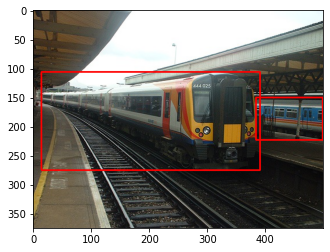

In [133]:
plt.imshow(img_copy)

# Batch processing

In [141]:
annots = list(Path('VOCdevkit/VOC2007/Annotations/').glob('*.xml'))

In [224]:
# random.seed(42)
sel_annots = random.sample(annots, 5)

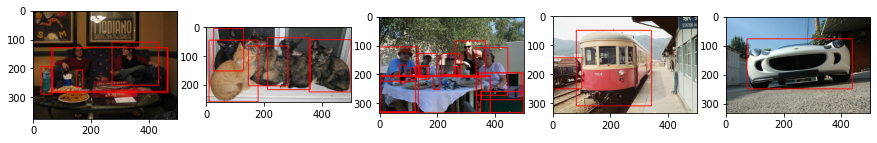

In [225]:
plt.figure(figsize=(15, 10))

for index in range(len(sel_annots)):
  root = ETree.parse(sel_annots[index])
  all_objects = root.findall('object')
  img_name = root.find('filename').text
  img_path = Path('VOCdevkit/VOC2007/JPEGImages') / img_name
  img = Image.open(img_path)

  txt_queries = []
  for obj in all_objects:
    txt_queries.append(obj.find('name').text)

  features = processor(
      text=np.unique(txt_queries).tolist(), images=img, return_tensors="pt"
  )

  with torch.no_grad():
    outputs = model(**features)

  target_sizes = torch.Tensor([img.size[::-1]])
  results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

  for i in range(len(results)):
    boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
    score_threshold = 0.15
    img_copy = np.array(img.copy())
    for box, score, label in zip(boxes, scores, labels):
        box = np.array([round(i, 2) for i in box.tolist()]).astype(int)
        if score >= score_threshold:
          cv2.rectangle(img_copy, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
  
  plt.subplot(1, 5, index + 1)
  plt.imshow(img_copy)

# Query images
- We use images to query intead of text

In [248]:
sel_annots = random.sample(annots, 5)

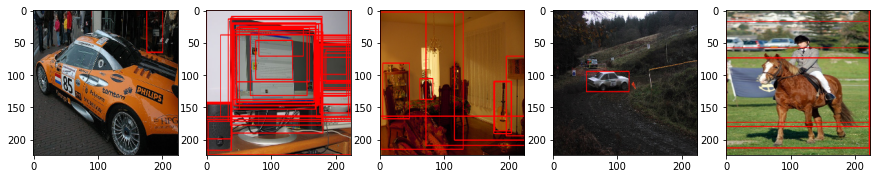

In [271]:
plt.figure(figsize=(15, 10))
for index in range(len(sel_annots)):
  root = ETree.parse(sel_annots[index])
  all_objects = root.findall('object')
  img_name = root.find('filename').text
  img_path = Path('VOCdevkit/VOC2007/JPEGImages') / img_name
  img = Image.open(img_path)
  img_np = np.array(img)

  img_queries = []
  for obj in all_objects:
    xmin = int(obj.find('bndbox').find('xmin').text)
    ymin = int(obj.find('bndbox').find('ymin').text)
    xmax = int(obj.find('bndbox').find('xmax').text)
    ymax = int(obj.find('bndbox').find('ymax').text)
    img_crop = img_np[ymin:ymax, xmin:xmax]
    img_queries.append(Image.fromarray(img_crop))
  
  inputs = processor(images=img, query_images=img_queries, return_tensors="pt")
  with torch.no_grad():
    outputs = model.image_guided_detection(**inputs)

  target_sizes = torch.Tensor([img.size[::-1] for _ in range(len(img_queries))])
  results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.7, nms_threshold=0.6, target_sizes=target_sizes)

  for i in range(len(results)):
    boxes, scores = results[i]["boxes"], results[i]["scores"]
    score_threshold = 0.6
    img_copy = np.array(img.copy())
    for box, score in zip(boxes, scores):
        box = np.array([round(i, 2) for i in box.tolist()]).astype(int)
        if score >= score_threshold:
          cv2.rectangle(img_copy, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
  
  plt.subplot(1, 5, index + 1)
  plt.imshow(cv2.resize(img_copy, (224, 224)))